In [3]:
!pip install pandas numpy seaborn matplotlib scikit-learn xgboost lightgbm imbalanced-learn scipy

StatementMeta(, 348c4909-cc75-463a-aaff-dc6e902cbd98, 9, Finished, Available, Finished)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 123.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 2.2.0
    Not uninstalling threadpoolctl at /home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages, outside environment /nfs4/pyenv-bc841928-42e4-4cc1-a976-b431ac0556fa
    Can't uninstall 'threadpoolctl'. No files were found to uninstall.
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Not uninstalling scikit-learn at /home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages, outside environment /nfs4/pyenv-bc841928-42e4-4cc1-a976-b431ac0556fa
    Can't uninstall 'scikit-learn'. No files were found to uninstall.

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may nee

In [4]:
import pandas as pd 
import numpy as np
import datetime as dt 
import seaborn as sns 
import joblib, os
import matplotlib.pyplot as plt 
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler

StatementMeta(, 348c4909-cc75-463a-aaff-dc6e902cbd98, 11, Finished, Available, Finished)

## **Load data**

In [5]:
df = spark.sql("""
SELECT 
    f.BillID,
    f.Channel,
    f.OrderFrom,
    f.TransactionDate,
    f.SalesAmount,
    f.CustomerID,
    f.VoucherStatus,
    f.Store_ID,
    c.CustomerGender,
    s.Region
FROM FabricStaging.fact_sales f
LEFT JOIN FabricStaging.dim_customer c
    ON f.CustomerID = c.CustomerID
LEFT JOIN FabricStaging.dim_store s
    ON f.Store_ID = s.Store_ID
""").toPandas()

df.head()


StatementMeta(, 348c4909-cc75-463a-aaff-dc6e902cbd98, 12, Finished, Available, Finished)

,BillID,Channel,OrderFrom,TransactionDate,SalesAmount,CustomerID,VoucherStatus,Store_ID,CustomerGender,Region
0,262144,Take Away,STORE,2022-01-17 00:00:00+00:00,277948,807144,No,S0380,Unknown,Hanoi
1,262145,Delivery,WEBSITE,2022-01-17 00:00:00+00:00,524281,1341545,No,S0403,Unknown,Hanoi
2,262146,Delivery,APP,2022-01-17 00:00:00+00:00,273796,1985092,No,S0391,Female,Southern Provinces
3,262147,Take Away,STORE,2022-01-17 00:00:00+00:00,104860,565430,No,S0410,Unknown,Southern Provinces
4,262148,Delivery,WEBSITE,2022-01-17 00:00:00+00:00,195694,1582466,Yes,S0507,Female,Ho Chi Minh City


In [6]:
df.info()

StatementMeta(, 348c4909-cc75-463a-aaff-dc6e902cbd98, 13, Finished, Available, Finished)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 10 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   BillID           1048575 non-null  int64 
 1   Channel          1048575 non-null  object
 2   OrderFrom        1048575 non-null  object
 3   TransactionDate  1048575 non-null  object
 4   SalesAmount      1048575 non-null  int64 
 5   CustomerID       1048575 non-null  int64 
 6   VoucherStatus    1048575 non-null  object
 7   Store_ID         1048575 non-null  object
 8   CustomerGender   1048575 non-null  object
 9   Region           1048575 non-null  object
dtypes: int64(3), object(7)
memory usage: 80.0+ MB


In [7]:
null=df.isnull()
for i in null.columns.values.tolist():
    print(i)
    print(null[i].value_counts())
    print("----------------------------------")

StatementMeta(, 348c4909-cc75-463a-aaff-dc6e902cbd98, 14, Finished, Available, Finished)

BillID
BillID
False    1048575
Name: count, dtype: int64
----------------------------------
Channel
Channel
False    1048575
Name: count, dtype: int64
----------------------------------
OrderFrom
OrderFrom
False    1048575
Name: count, dtype: int64
----------------------------------
TransactionDate
TransactionDate
False    1048575
Name: count, dtype: int64
----------------------------------
SalesAmount
SalesAmount
False    1048575
Name: count, dtype: int64
----------------------------------
CustomerID
CustomerID
False    1048575
Name: count, dtype: int64
----------------------------------
VoucherStatus
VoucherStatus
False    1048575
Name: count, dtype: int64
----------------------------------
Store_ID
Store_ID
False    1048575
Name: count, dtype: int64
----------------------------------
CustomerGender
CustomerGender
False    1048575
Name: count, dtype: int64
----------------------------------
Region
Region
False    1048575
Name: count, dtype: int64
----------------------------------


## **Bivariate Analysis**
Bivariate Analysis meaning two variable analysis
Column can be of two types - 1. Continuous and 2. Categorical
So Bivariate Analysis can be of THREE TYPES
- Continuous vs Continuous - Correlation Coefficient and VIF
 - Categorical vs Categorical - Chi Square Test
 - Categorical vs Continuous - T Test(N < 30), Z Test(N > 30) & ANOVA

In [8]:
df2 = df
df2

StatementMeta(, 348c4909-cc75-463a-aaff-dc6e902cbd98, 15, Finished, Available, Finished)

,BillID,Channel,OrderFrom,TransactionDate,SalesAmount,CustomerID,VoucherStatus,Store_ID,CustomerGender,Region
0,262144,Take Away,STORE,2022-01-17 00:00:00+00:00,277948,807144,No,S0380,Unknown,Hanoi
1,262145,Delivery,WEBSITE,2022-01-17 00:00:00+00:00,524281,1341545,No,S0403,Unknown,Hanoi
2,262146,Delivery,APP,2022-01-17 00:00:00+00:00,273796,1985092,No,S0391,Female,Southern Provinces
3,262147,Take Away,STORE,2022-01-17 00:00:00+00:00,104860,565430,No,S0410,Unknown,Southern Provinces
4,262148,Delivery,WEBSITE,2022-01-17 00:00:00+00:00,195694,1582466,Yes,S0507,Female,Ho Chi Minh City
...,...,...,...,...,...,...,...,...,...,...
1048570,262139,Take Away,STORE,2022-01-17 00:00:00+00:00,512359,1054991,No,S0381,Unknown,Hanoi
1048571,262140,Delivery,WEBSITE,2022-01-17 00:00:00+00:00,314398,1488964,No,S0380,Unknown,Hanoi
1048572,262141,Take Away,STORE,2022-01-17 00:00:00+00:00,118904,1667039,No,S0391,Unknown,Southern Provinces
1048573,262142,Delivery,CALL CENTER,2022-01-17 00:00:00+00:00,387795,1879005,No,S0398,Unknown,Ho Chi Minh City


In [9]:
# Channel vs VoucherStatus
print("\nChannel vs VoucherStatus:")
print("Giả thuyết H₀: Việc dùng voucher không phụ thuộc vào kênh đặt hàng.")
print("Giả thuyết H₁: Việc dùng voucher thay đổi tùy theo kênh đặt hàng.")
channel_cross = pd.crosstab(df2['Channel'], df2['VoucherStatus'], normalize='index')
print(channel_cross)
chi2, p, _, _ = chi2_contingency(pd.crosstab(df2['Channel'], df2['VoucherStatus']))
print(f"Giá trị p-value: {p}")
if p < 0.05:
    print("Kết luận: Bác bỏ H₀ - Kênh đặt hàng có ảnh hưởng.")
else:
    print("Kết luận: Không bác bỏ H₀ - Kênh đặt hàng không ảnh hưởng rõ rệt.")

StatementMeta(, 348c4909-cc75-463a-aaff-dc6e902cbd98, 16, Finished, Available, Finished)


Channel vs VoucherStatus:
Giả thuyết H₀: Việc dùng voucher không phụ thuộc vào kênh đặt hàng.
Giả thuyết H₁: Việc dùng voucher thay đổi tùy theo kênh đặt hàng.
VoucherStatus        No       Yes
Channel                          
Delivery       0.885586  0.114414
Dine In        0.951546  0.048454
Take Away      0.928127  0.071873
Giá trị p-value: 0.0
Kết luận: Bác bỏ H₀ - Kênh đặt hàng có ảnh hưởng.


In [10]:
# OrderFrom vs VoucherStatus
print("\nOrderFrom vs VoucherStatus:")
print("Giả thuyết H₀: Việc dùng voucher không phụ thuộc vào kênh đặt hàng.")
print("Giả thuyết H₁: Việc dùng voucher thay đổi tùy theo kênh đặt hàng.")
orderfrom_cross = pd.crosstab(df2['OrderFrom'], df2['VoucherStatus'], normalize='index')
print(orderfrom_cross)
chi2, p, _, _ = chi2_contingency(pd.crosstab(df2['OrderFrom'], df2['VoucherStatus']))
print(f"Giá trị p-value: {p}")
if p < 0.05:
    print("Kết luận: Bác bỏ H₀ - Kênh đặt hàng có ảnh hưởng.")
else:
    print("Kết luận: Không bác bỏ H₀ - Kênh đặt hàng không ảnh hưởng rõ rệt.")

StatementMeta(, 348c4909-cc75-463a-aaff-dc6e902cbd98, 17, Finished, Available, Finished)


OrderFrom vs VoucherStatus:
Giả thuyết H₀: Việc dùng voucher không phụ thuộc vào kênh đặt hàng.
Giả thuyết H₁: Việc dùng voucher thay đổi tùy theo kênh đặt hàng.
VoucherStatus        No       Yes
OrderFrom                        
APP            0.567624  0.432376
CALL CENTER    0.996375  0.003625
STORE          0.984264  0.015736
WEBSITE        0.820767  0.179233
Giá trị p-value: 0.0
Kết luận: Bác bỏ H₀ - Kênh đặt hàng có ảnh hưởng.


In [11]:
# TransactionDate vs VoucherStatus
df2['TransactionDate'] = pd.to_datetime(df2['TransactionDate'], errors='coerce')
df2['VoucherStatus'] = df2['VoucherStatus'].str.strip().str.lower()
# Tạo biến thời gian
df2['Year'] = df2['TransactionDate'].dt.year
df2['Month'] = df2['TransactionDate'].dt.month
df2['Quarter'] = df2['TransactionDate'].dt.quarter
df2['DayOfWeek'] = df2['TransactionDate'].dt.day_name()
# Hàm kiểm định Chi-square
def chi_square_test(var):
    ctab = pd.crosstab(df2[var], df2['VoucherStatus'], normalize='index')
    chi2, p, _, _ = chi2_contingency(pd.crosstab(df2[var], df2['VoucherStatus']))
    print(f"\n🔹 {var} vs VoucherStatus")
    print(ctab)
    print(f"p-value = {p:.5f}")
    if p < 0.05:
        print(f"➡️ Bác bỏ H₀ → {var} có ảnh hưởng đến việc dùng voucher.")
    else:
        print(f"➡️ Không bác bỏ H₀ → {var} không có ảnh hưởng rõ rệt.")
    return var, p

# Chạy kiểm định cho các mốc thời gian
results = []
for var in ['Month', 'Quarter', 'DayOfWeek']:
    results.append(chi_square_test(var))

StatementMeta(, 348c4909-cc75-463a-aaff-dc6e902cbd98, 18, Finished, Available, Finished)


🔹 Month vs VoucherStatus
VoucherStatus        no       yes
Month                            
1              0.917595  0.082405
2              0.961156  0.038844
3              0.958579  0.041421
4              0.947702  0.052298
5              0.937146  0.062854
6              0.948140  0.051860
7              0.896907  0.103093
8              0.790031  0.209969
9              0.829139  0.170861
10             0.906456  0.093544
11             0.903621  0.096379
12             0.897613  0.102387
p-value = 0.00000
➡️ Bác bỏ H₀ → Month có ảnh hưởng đến việc dùng voucher.

🔹 Quarter vs VoucherStatus
VoucherStatus        no       yes
Quarter                          
1              0.943100  0.056900
2              0.944245  0.055755
3              0.839650  0.160350
4              0.902475  0.097525
p-value = 0.00000
➡️ Bác bỏ H₀ → Quarter có ảnh hưởng đến việc dùng voucher.

🔹 DayOfWeek vs VoucherStatus
VoucherStatus        no       yes
DayOfWeek                        
Friday         0

In [12]:
# SalesAmount vs VoucherStatus
print("\nSalesAmount vs VoucherStatus:")
print("Giả thuyết H₀: Giá trị đơn hàng trung bình giống nhau giữa hai nhóm có/không dùng voucher.")
print("Giả thuyết H₁: Giá trị đơn hàng trung bình khác nhau giữa hai nhóm.")
# Chuẩn hóa dữ liệu
df2['VoucherStatus'] = df2['VoucherStatus'].str.strip().str.lower()
df2['SalesAmount'] = pd.to_numeric(df2['SalesAmount'], errors='coerce')
# Tách hai nhóm
yes_sales = df2[df2['VoucherStatus'] == 'yes']['SalesAmount']
no_sales = df2[df2['VoucherStatus'] == 'no']['SalesAmount']
# Kiểm tra số lượng mẫu
print(f"Số lượng mẫu - Yes: {len(yes_sales)}, No: {len(no_sales)}")
# Kiểm định t-test (giả định 2 nhóm độc lập, phương sai không nhất thiết bằng nhau)
t_stat, p_val = ttest_ind(yes_sales, no_sales, equal_var=False, nan_policy='omit')
print(f"Giá trị p-value: {p_val:.6f}")
if np.isnan(p_val):
    print("⚠️ Không thể tính p-value. Có thể do dữ liệu trống hoặc lỗi định dạng.")
elif p_val < 0.05:
    print("✅ Bác bỏ H₀ - Giá trị đơn hàng có khác biệt giữa hai nhóm.")
else:
    print("❌ Không bác bỏ H₀ - Giá trị đơn hàng không khác biệt rõ rệt.")


StatementMeta(, 348c4909-cc75-463a-aaff-dc6e902cbd98, 19, Finished, Available, Finished)


SalesAmount vs VoucherStatus:
Giả thuyết H₀: Giá trị đơn hàng trung bình giống nhau giữa hai nhóm có/không dùng voucher.
Giả thuyết H₁: Giá trị đơn hàng trung bình khác nhau giữa hai nhóm.
Số lượng mẫu - Yes: 96123, No: 952452
Giá trị p-value: 0.000000
✅ Bác bỏ H₀ - Giá trị đơn hàng có khác biệt giữa hai nhóm.


In [13]:
# CustomerGender vs VoucherStatus
print("\nCustomerGender vs VoucherStatus:")
print("Giả thuyết H₀: Việc dùng voucher không phụ thuộc vào giới tính.")
print("Giả thuyết H₁: Việc dùng voucher thay đổi tùy theo giới tính.")
gender_cross = pd.crosstab(df2['CustomerGender'], df2['VoucherStatus'], normalize='index')
print(gender_cross)
chi2, p, _, _ = chi2_contingency(pd.crosstab(df2['CustomerGender'], df2['VoucherStatus']))
print(f"Giá trị p-value: {p}")
if p < 0.05:
    print("Kết luận: Bác bỏ H₀ - Giới tính có ảnh hưởng.")
else:
    print("Kết luận: Không bác bỏ H₀ - Giới tính không ảnh hưởng rõ rệt.")

StatementMeta(, 348c4909-cc75-463a-aaff-dc6e902cbd98, 20, Finished, Available, Finished)


CustomerGender vs VoucherStatus:
Giả thuyết H₀: Việc dùng voucher không phụ thuộc vào giới tính.
Giả thuyết H₁: Việc dùng voucher thay đổi tùy theo giới tính.
VoucherStatus         no       yes
CustomerGender                    
Female          0.819054  0.180946
Male            0.798674  0.201326
Unknown         0.975446  0.024554
Giá trị p-value: 0.0
Kết luận: Bác bỏ H₀ - Giới tính có ảnh hưởng.


In [14]:
# Province vs VoucherStatus
print("\nRegion vs VoucherStatus:")
print("Giả thuyết H₀: Việc dùng voucher không phụ thuộc vào khu vực.")
print("Giả thuyết H₁: Việc dùng voucher thay đổi tùy theo khu vực.")
province_cross = pd.crosstab(df2['Region'], df2['VoucherStatus'], normalize='index')
print(province_cross)
chi2, p, _, _ = chi2_contingency(pd.crosstab(df2['Region'], df2['VoucherStatus']))
print(f"Giá trị p-value: {p}")
if p < 0.05:
    print("Kết luận: Bác bỏ H₀ - Khu vực có ảnh hưởng.")
else:
    print("Kết luận: Không bác bỏ H₀ - Khu vực không ảnh hưởng rõ rệt.")

StatementMeta(, 348c4909-cc75-463a-aaff-dc6e902cbd98, 21, Finished, Available, Finished)


Region vs VoucherStatus:
Giả thuyết H₀: Việc dùng voucher không phụ thuộc vào khu vực.
Giả thuyết H₁: Việc dùng voucher thay đổi tùy theo khu vực.
VoucherStatus             no       yes
Region                                
Hanoi               0.906147  0.093853
Ho Chi Minh City    0.887169  0.112831
Northern Provinces  0.945401  0.054599
Southern Provinces  0.931769  0.068231
Giá trị p-value: 0.0
Kết luận: Bác bỏ H₀ - Khu vực có ảnh hưởng.


### **Kết luận**
###### **Sau khi thực hiện phân tích mối quan hệ giữa biến mục tiêu VoucherStatus và các biến độc lập như Channel, OrderFrom, TransactionDate, SalesAmount, CustomerGender, và Region. Kết quả cho thấy tất cả các biến sẽ được giữ lại trong giai đoạn huấn luyện mô hình để đảm bảo mô hình có thể tự học và đánh giá mức độ đóng góp của từng biến một cách khách quan.**

## **Train model**

In [15]:
# --- 1️⃣ Lọc dữ liệu giai đoạn 2021–2022 ---
df_train = df2[(df2['Year'] >= 2021) & (df2['Year'] <= 2022)].copy()
print(f"Số lượng bản ghi dùng để train: {len(df_train):,}")
print(df_train['Year'].value_counts().sort_index())
# --- 2️⃣ Chọn đặc trưng ---
features = [
    'Channel',
    'OrderFrom',
    'CustomerGender',
    'Region',        
    'SalesAmount',
    'Year',
    'Month',
    'DayOfWeek'
]
# --- 3️⃣ One-hot encoding cho biến phân loại ---
X = pd.get_dummies(df_train[features], drop_first=True)
y = df_train['VoucherStatus'].map({'no': 0, 'yes': 1})

# --- 4️⃣ Chia tập Train/Test ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# --- 5️⃣ Undersampling để cân bằng lớp ---
rus = RandomUnderSampler(random_state=42, sampling_strategy='majority')
X_train_balanced, y_train_balanced = rus.fit_resample(X_train, y_train)

# --- 6️⃣ Kiểm tra kết quả ---
print("\n📊 Phân bố tập Train sau Undersampling:")
print(pd.Series(y_train_balanced).value_counts())
print("\n✅ Kích thước dữ liệu sau chuẩn bị:")
print(f"Train: {X_train_balanced.shape}, Test: {X_test.shape}")


StatementMeta(, 348c4909-cc75-463a-aaff-dc6e902cbd98, 22, Finished, Available, Finished)

Số lượng bản ghi dùng để train: 1,029,067
Year
2021    216908
2022    812159
Name: count, dtype: int64

📊 Phân bố tập Train sau Undersampling:
VoucherStatus
0    74004
1    74004
Name: count, dtype: int64

✅ Kích thước dữ liệu sau chuẩn bị:
Train: (148008, 19), Test: (205814, 19)


In [16]:
# --------------------------- RANDOM FOREST ---------------------------
print("🌲 Training Random Forest...")
model_rf = RandomForestClassifier(random_state=42, n_estimators=200)
model_rf.fit(X_train_balanced, y_train_balanced)

# Dự đoán
y_pred_rf = model_rf.predict(X_test)
y_prob_rf = model_rf.predict_proba(X_test)[:, 1]

# Đánh giá
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_report = classification_report(y_test, y_pred_rf, target_names=['No', 'Yes'], output_dict=True)
rf_fpr, rf_tpr, _ = roc_curve(y_test, y_prob_rf)
rf_auc = auc(rf_fpr, rf_tpr)
print(f"✅ Random Forest completed - Accuracy: {rf_accuracy:.4f}, AUC: {rf_auc:.4f}")


# --------------------------- XGBOOST ---------------------------
print("\n🚀 Training XGBoost...")
model_xgb = XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False)
model_xgb.fit(X_train_balanced, y_train_balanced)

# Dự đoán
y_pred_xgb = model_xgb.predict(X_test)
y_prob_xgb = model_xgb.predict_proba(X_test)[:, 1]

# Đánh giá
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_report = classification_report(y_test, y_pred_xgb, target_names=['No', 'Yes'], output_dict=True)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, y_prob_xgb)
xgb_auc = auc(xgb_fpr, xgb_tpr)
print(f"✅ XGBoost completed - Accuracy: {xgb_accuracy:.4f}, AUC: {xgb_auc:.4f}")


# --------------------------- LIGHTGBM ---------------------------
print("\n💡 Training LightGBM...")
model_lgb = LGBMClassifier(random_state=42, n_estimators=200)
model_lgb.fit(X_train_balanced, y_train_balanced)

# Dự đoán
y_pred_lgb = model_lgb.predict(X_test)
y_prob_lgb = model_lgb.predict_proba(X_test)[:, 1]

# Đánh giá
lgb_accuracy = accuracy_score(y_test, y_pred_lgb)
lgb_report = classification_report(y_test, y_pred_lgb, target_names=['No', 'Yes'], output_dict=True)
lgb_fpr, lgb_tpr, _ = roc_curve(y_test, y_prob_lgb)
lgb_auc = auc(lgb_fpr, lgb_tpr)
print(f"✅ LightGBM completed - Accuracy: {lgb_accuracy:.4f}, AUC: {lgb_auc:.4f}")


StatementMeta(, 348c4909-cc75-463a-aaff-dc6e902cbd98, 23, Finished, Available, Finished)

🌲 Training Random Forest...
✅ Random Forest completed - Accuracy: 0.8220, AUC: 0.9104

🚀 Training XGBoost...


✅ XGBoost completed - Accuracy: 0.8359, AUC: 0.9329

💡 Training LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 74004, number of negative: 74004
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 303
[LightGBM] [Info] Number of data points in the train set: 148008, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


✅ LightGBM completed - Accuracy: 0.8379, AUC: 0.9337


StatementMeta(, 348c4909-cc75-463a-aaff-dc6e902cbd98, 24, Finished, Available, Finished)


Mô hình: Random Forest | Accuracy: 0.8220
Class      Precision  Recall     F1-Score   Support   
--------------------------------------------------
No         0.9798     0.8214     0.8936     187313    
Yes        0.3142     0.8284     0.4556     18501     
Macro Avg  0.6470     0.8249     0.6746     205814    
--------------------------------------------------

Mô hình: XGBoost | Accuracy: 0.8359
Class      Precision  Recall     F1-Score   Support   
--------------------------------------------------
No         0.9878     0.8299     0.9020     187313    
Yes        0.3424     0.8965     0.4955     18501     
Macro Avg  0.6651     0.8632     0.6988     205814    
--------------------------------------------------

Mô hình: LightGBM | Accuracy: 0.8379
Class      Precision  Recall     F1-Score   Support   
--------------------------------------------------
No         0.9879     0.8321     0.9033     187313    
Yes        0.3453     0.8965     0.4986     18501     
Macro Avg  0.6666     

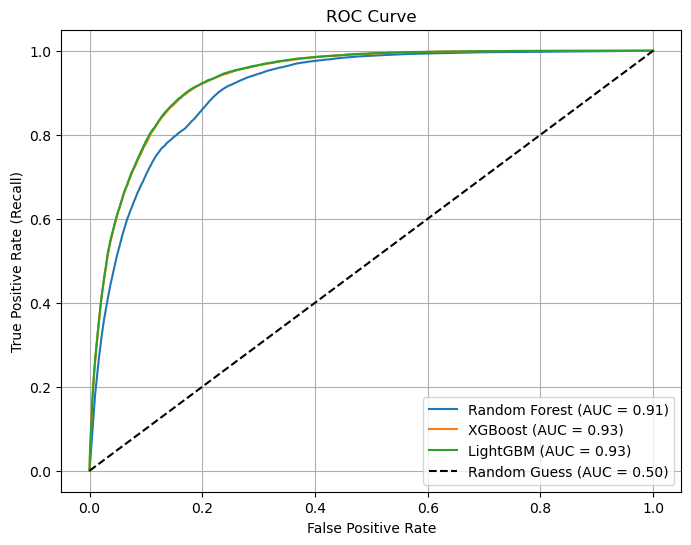

In [17]:
models = {
    'Random Forest': {'accuracy': rf_accuracy, 'report': rf_report, 'fpr': rf_fpr, 'tpr': rf_tpr, 'auc': rf_auc},
    'XGBoost': {'accuracy': xgb_accuracy, 'report': xgb_report, 'fpr': xgb_fpr, 'tpr': xgb_tpr, 'auc': xgb_auc},
    'LightGBM': {'accuracy': lgb_accuracy, 'report': lgb_report, 'fpr': lgb_fpr, 'tpr': lgb_tpr, 'auc': lgb_auc}
}

# Hiển thị báo cáo hiệu suất
for name, result in models.items():
    print(f"\nMô hình: {name} | Accuracy: {result['accuracy']:.4f}")
    print(f"{'Class':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
    print("-" * 50)
    for cls in ['No', 'Yes']:
        print(f"{cls:<10} {result['report'][cls]['precision']:<10.4f} {result['report'][cls]['recall']:<10.4f} {result['report'][cls]['f1-score']:<10.4f} {result['report'][cls]['support']:<10.0f}")
    print(f"{'Macro Avg':<10} {result['report']['macro avg']['precision']:<10.4f} {result['report']['macro avg']['recall']:<10.4f} {result['report']['macro avg']['f1-score']:<10.4f} {result['report']['macro avg']['support']:<10.0f}")
    print("-" * 50)

# Vẽ ROC Curve 
plt.figure(figsize=(8, 6))
for name, result in models.items():
    plt.plot(result['fpr'], result['tpr'], label=f'{name} (AUC = {result["auc"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [18]:
# 🏆 Chọn model tốt nhất theo AUC
# =========================================================
best_model_name = max(models, key=lambda x: models[x]['auc'])
best_auc = models[best_model_name]['auc']
if best_model_name == 'Random Forest':
    best_model = model_rf
elif best_model_name == 'XGBoost':
    best_model = model_xgb
else:
    best_model = model_lgb
print(f"\n🏆 Model tốt nhất: {best_model_name} (AUC = {best_auc:.4f})")

StatementMeta(, 348c4909-cc75-463a-aaff-dc6e902cbd98, 25, Finished, Available, Finished)


🏆 Model tốt nhất: LightGBM (AUC = 0.9337)


In [19]:
# =========================================================
# 💾 Lưu model tốt nhất vào Lakehouse (Fabric)
# =========================================================
save_dir = "/lakehouse/default/Files/Models"
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, "best_voucher_model.pkl")
joblib.dump(best_model, model_path)
print(f"💾 Đã lưu model tốt nhất '{best_model_name}' vào: {model_path}")

StatementMeta(, 348c4909-cc75-463a-aaff-dc6e902cbd98, 26, Finished, Available, Finished)

💾 Đã lưu model tốt nhất 'LightGBM' vào: /lakehouse/default/Files/Models/best_voucher_model.pkl
